In [5]:
# Import relevant modules

import os

import numpy as np
import healpy as hp
from scipy.stats import poisson
from scipy.optimize import minimize
import emcee
import corner

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Download _Fermi_ gamma-ray data and templates

Download example _Fermi_ data and templates (already downloaded in this repo). This was made for the non-Poissonian template fitting package [here](https://nptfit.readthedocs.io/en/latest/Example1_Overview_of_the_Fermi_Data.html).

In [6]:
# # Assumes wget is available! Otherwise, use curl or download manually
# # from https://dspace.mit.edu/handle/1721.1/105492
# os.system("wget https://dspace.mit.edu/bitstream/handle/1721.1/105492/fermi_data.tar.gz?sequence=5");
# os.system("tar -xvf fermi_data.tar.gz?sequence=5");
# os.system("rm -r fermi_data.tar.gz*");

Here are the contents.

In [7]:
! ls fermi_data/

README.txt             template_bub.npy       template_iso.npy
fermidata_counts.npy   template_dif.npy       template_psc.npy
fermidata_exposure.npy template_dsk.npy
fermidata_pscmask.npy  template_gce.npy


Each of these is just a numpy array that describes a `HEALPix`-binned map of `nside=128` (which measure spatial resolution; higher `nside` means finer binning). See [here](https://healpix.jpl.nasa.gov/pdf/intro.pdf) or [here](https://healpix.jpl.nasa.gov/html/intro.htm) for more info on `HEALPix`.

In [9]:
# np.shape()

## Load data and templates

This is the _Fermi_ gamma-ray data counts map (after some quality cuts) between 2 and 20 GeV. We can visualize a `HEALPix` map with `healpy.mollview()`:

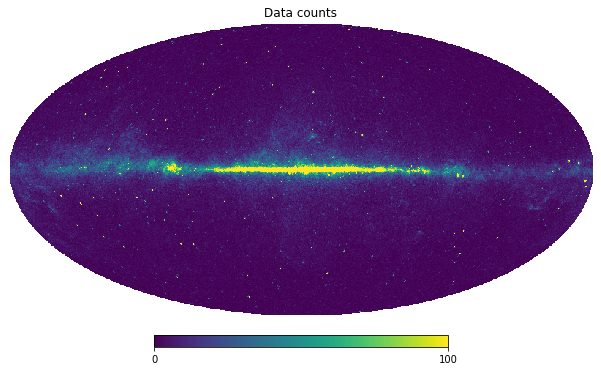

In [10]:
data = np.load('fermi_data/fermidata_counts.npy')
hp.mollview(data, title='Data counts',max=100)

This is an example of a template modeling the astrophysical diffuse background from our Galaxy. There is a large degree of uncertainty on this contribution (many knobs that can be turned to produce different versions of this).

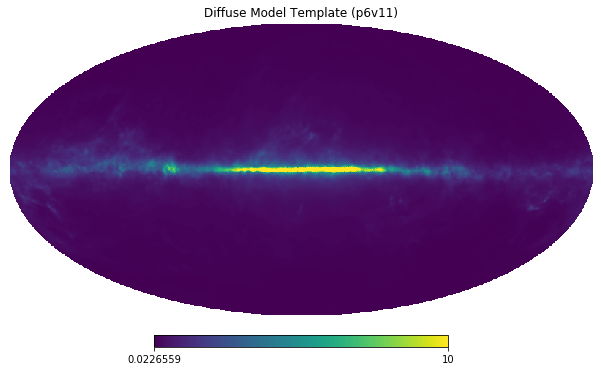

In [11]:
temp_dif = np.load('fermi_data/template_dif.npy')
hp.mollview(temp_dif, title='Diffuse Model Template (p6v11)',max=10)

This is a template modeling nearly-isotropic background emission.

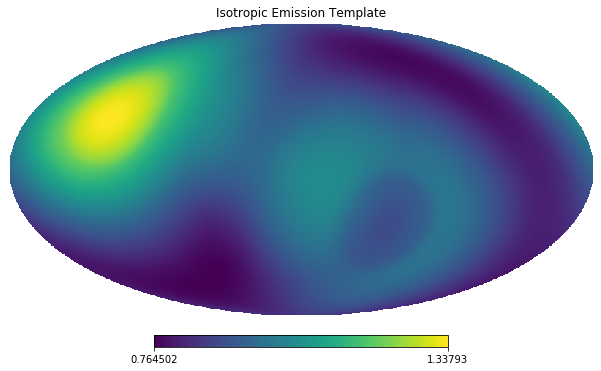

In [12]:
temp_iso = np.load('fermi_data/template_iso.npy')
hp.mollview(temp_iso, title='Isotropic Emission Template')

This is a template modeling emission from the _Fermi_ bubbles, thought to be astrophysical but precise origin is unknown.

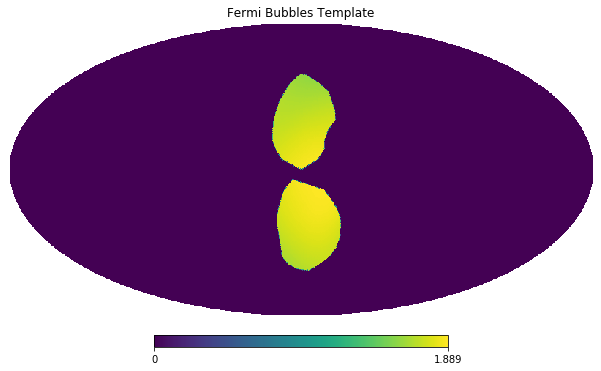

In [13]:
temp_bub = np.load('fermi_data/template_bub.npy')
hp.mollview(temp_bub, title='Fermi Bubbles Template')

This is a template modeling emission from point sources that have been individually resolved by _Fermi_.

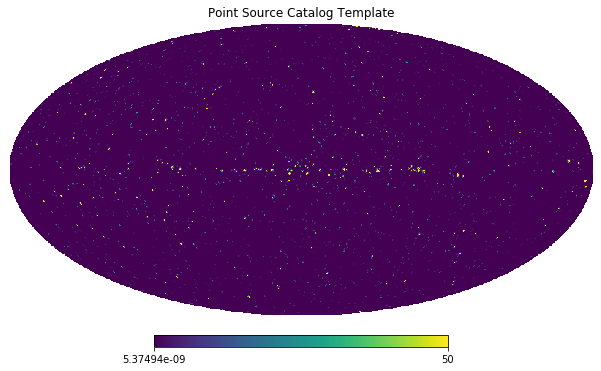

In [14]:
temp_psc = np.load('fermi_data/template_psc.npy')
hp.mollview(temp_psc, title='Point Source Catalog Template',max=50)

This is a model for emission from dark matter annihilation at the center of the Galaxy. This is the **signal template** and assumes dark matter is distributed in our Galaxy following an [NFW profile](https://en.wikipedia.org/wiki/Navarro%E2%80%93Frenk%E2%80%93White_profile).

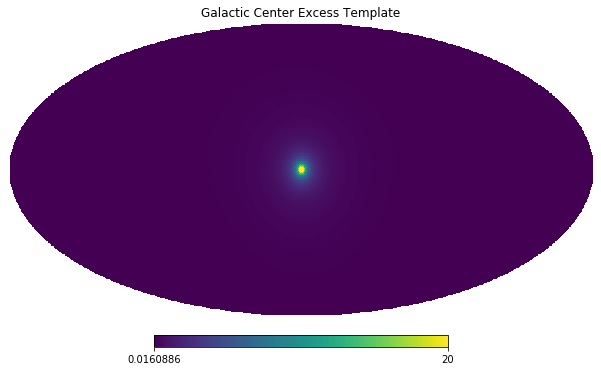

In [15]:
temp_dm = np.load('fermi_data/template_gce.npy')
hp.mollview(temp_dm, title='Galactic Center Excess Template',max=20)

## Define likelihood

The likelihood is just a product of the bin-wise Poisson likelihoods. **We fit for the overall normalization of the spatial templates** ($A_\mathrm{dm}, A_\mathrm{bub}, \ldots$), which are the free parameters.

In [25]:
def log_like(theta, data):
    """ Bin-wise Poisson likelihood with DM signal
    """
    # The parameters are the overall norms of each template
    A_dm, A_bub, A_psc, A_iso, A_dif = theta
    
    # Model is the sum of templates with free normalizations
    mu = A_dm * temp_dm + A_bub * temp_bub + A_psc * temp_psc + A_iso * temp_iso + A_dif * temp_dif
    
    # Bin-wise Poisson sum
    return np.sum(poisson.logpmf(data, mu))

def log_like_no_dm(theta, data):
    """ Bin-wise Poisson likelihood without DM signal
    """
    # The parameters are the overall norms of each template
    A_bub, A_psc, A_iso, A_dif = theta
    
    # Model is the sum of templates with free normalizations
    mu = A_bub * temp_bub + A_psc * temp_psc + A_iso * temp_iso + A_dif * temp_dif
    
    # Bin-wise Poisson sum
    return np.sum(poisson.logpmf(data, mu))


In [29]:
temp_dm.shape

(196608,)

## Do fit using `scipy.optimize.minimize()`

Minimize the ($-$)log-likelihood with simple scan using `scipy.optimize.minimize()`.

Scan including a signal:

In [27]:
opt_with_signal = minimize(lambda theta: -log_like(theta, data), x0=[1.] * 5, bounds=[[0, 20]] * 5, method='SLSQP')
opt_with_signal

     fun: 436660.8703465765
     jac: array([0.        , 0.05859375, 0.109375  , 0.01171875, 0.0078125 ])
 message: 'Optimization terminated successfully.'
    nfev: 141
     nit: 18
    njev: 18
  status: 0
 success: True
       x: array([ 0.8971301 ,  0.43738578,  1.09130553,  0.75777112, 13.36802341])

Scan without a signal:

In [66]:
opt_no_signal = minimize(lambda theta: -log_like_no_dm(theta, data), x0=[1.] * 4, bounds=[[0, 20]] * 4, method='SLSQP')
opt_no_signal

     fun: 437253.94930616487
     jac: array([ 0.00390625,  0.        , -0.01953125,  0.015625  ])
 message: 'Optimization terminated successfully.'
    nfev: 104
     nit: 15
    njev: 15
  status: 0
 success: True
       x: array([ 0.59725272,  1.09102958,  0.77696131, 13.57145866])

Significance of signal as difference of (twice) LLs:

In [67]:
TS = - 2 * (opt_with_signal.fun - opt_no_signal.fun)
print("The TS for a DM signal is", TS)

The TS for a DM signal is 1186.1579191767378


## Do a Bayesian scan with `emcee`

In [76]:
# Define priors
def log_prior(theta):
    for A in theta:
        if not 0. < A < 20.:
            return -np.inf
    return 0

def log_prob(theta):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_like(theta, data)


Sample posterior with `emcee`:

In [77]:
pos = opt_with_signal.x + 1e-4 * np.random.randn(10, len(opt_with_signal.x))
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob)
sampler.run_mcmc(pos, 500, progress='notebook');

Plot sampled posteriors compared to MLE estimates obtained above:

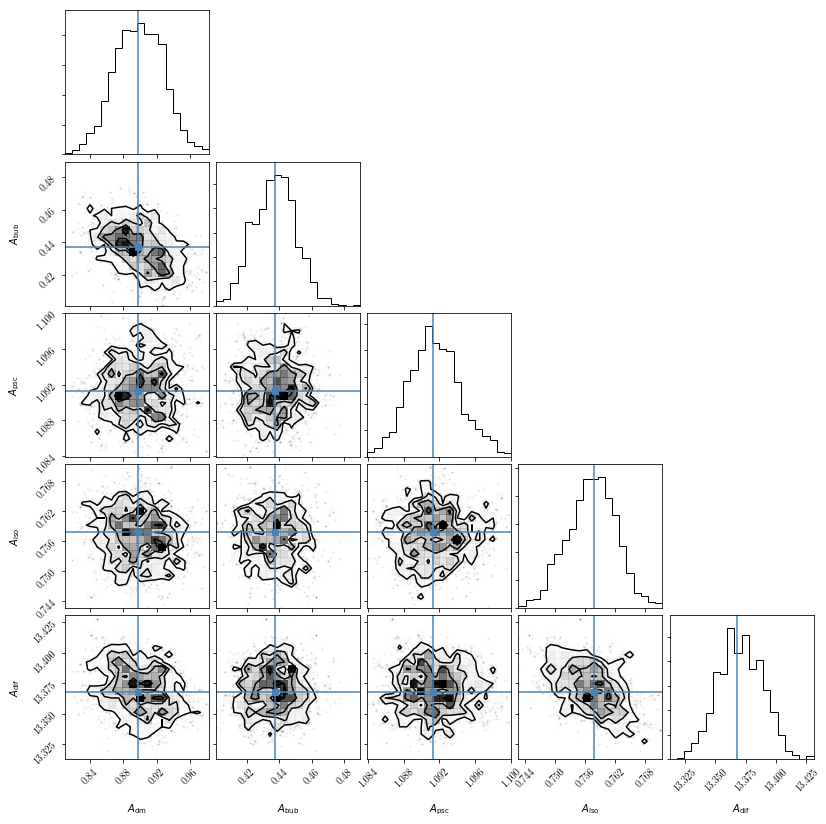

In [82]:
flat_samples = sampler.get_chain(discard=100, thin=2, flat=True)
corner.corner(flat_samples, labels=['$A_\mathrm{dm}$', '$A_\mathrm{bub}$', '$A_\mathrm{psc}$', '$A_\mathrm{iso}$', '$A_\mathrm{dif}$'], truths=opt_with_signal.x);

## Plot the "best-fit" model and residuals

Obtained best-fit model of data as the sum of model templates weighed by the best-fit norm we obtain from the fit above.

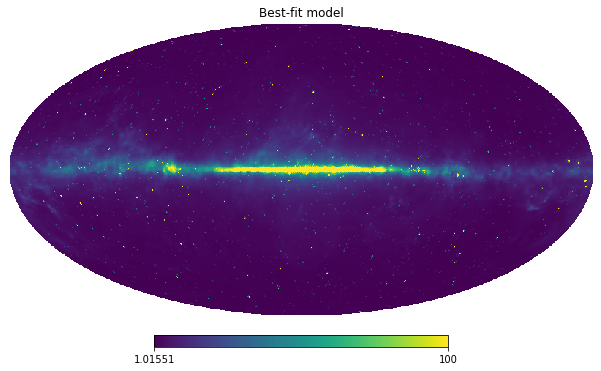

In [38]:
A_dm, A_bub, A_psc, A_iso, A_dif = opt_with_signal.x
mu_best_fit = A_dm * temp_dm + A_bub * temp_bub + A_psc * temp_psc + A_iso * temp_iso + A_dif * temp_dif

hp.mollview(mu_best_fit, max=100, title='Best-fit model')

Plot the data residuals compared to this best-fit model. Large residuals along the plane are seen---the model doesn't do a great job of describing the data!

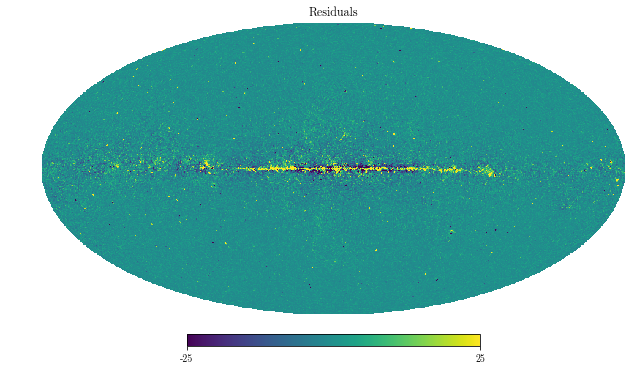

In [89]:
hp.mollview(data - mu_best_fit, min = -25, max=25, title='Residuals')